In [16]:
import numpy as np
import sklearn
from numpy import tanh
import sys
sys.path.append('..')
import pandas as pd
from utils import load_narma
import matplotlib.pyplot as plt
from esn import EchoStateNetwork, LeastMeanSquares
from itertools import product
from sklearn.linear_model import Ridge
import importlib
import esn
importlib.reload(esn)
from esn import EchoStateNetwork, LeastMeanSquares

# Narma

In [17]:
mae = sklearn.metrics.mean_absolute_error
mse = sklearn.metrics.mean_squared_error

In [18]:
x_train,y_train, x_val, y_val, x_test, y_test = load_narma('../dataset/NARMA10.csv', format='np')
y_train.shape

(4000, 1)

In [25]:
esn = EchoStateNetwork(input_size= 1, hidden_size=300, rho_h=0.9, omega_x=1.0, density=1, head=LeastMeanSquares())

esn.fit(x_train, y_train, washout=1000)
y_pred= esn.predict(x_val)


In [26]:
mae(y_val, y_pred), mse(y_val, y_pred)  

(0.0010057708809617907, 1.7547383873269595e-06)

## Model Selection

In [38]:
hidden_sizes = [300, 500, 1000]
rhos = [ 0.9, 0.99, 1, 1.1]
input_scaling = [ 1, 1.5]
washouts =[1000, 100]
head = LeastMeanSquares()
results = {}
total_tries = len(hidden_sizes) * len(rhos) * len(input_scaling) * len(washouts)
n_guesses = 5
for i, (hidden_size, rho_h, omega_x, washout) in enumerate(product(hidden_sizes, rhos,input_scaling, washouts)):
    mean_mae = 0
    mean_mse = 0
    for n in range(n_guesses):
        esn = EchoStateNetwork(input_size=1, 
                            hidden_size=hidden_size, 
                            rho_h=rho_h, 
                            density=1,
                            omega_x=omega_x, 
                            head=head)
        esn.fit(x_train, y_train, washout=washout)
        y_pred = esn.predict(x_val)
        mean_mae += mae(y_val, y_pred)
        mean_mse += mse(y_val, y_pred)
    mean_mae /= n_guesses
    mean_mse /= n_guesses
    
    print(f"{i+1}/{total_tries}")
    print(f"hidden_size: {hidden_size}, rho_h: {rho_h}, omega_x: {omega_x}, washout: {washout}")
    print(f"MAE: {mean_mae}, MSE: {mean_mse}")

    results[(hidden_size, rho_h,  omega_x, washout)] = (mean_mae, mean_mse)
    

1/48
hidden_size: 300, rho_h: 0.9, omega_x: 1, washout: 1000
MAE: 0.0010356565586989745, MSE: 1.8763113701323153e-06
2/48
hidden_size: 300, rho_h: 0.9, omega_x: 1, washout: 100
MAE: 0.00116467629893062, MSE: 2.3935505847998085e-06
3/48
hidden_size: 300, rho_h: 0.9, omega_x: 1.5, washout: 1000
MAE: 0.0017060629426996455, MSE: 5.196554346671898e-06
4/48
hidden_size: 300, rho_h: 0.9, omega_x: 1.5, washout: 100
MAE: 0.0017656427329881506, MSE: 5.720892905611524e-06
5/48
hidden_size: 300, rho_h: 0.99, omega_x: 1, washout: 1000
MAE: 0.0009332227982425442, MSE: 1.5109731596535587e-06
6/48
hidden_size: 300, rho_h: 0.99, omega_x: 1, washout: 100
MAE: 0.0009491259678373657, MSE: 1.6019675510370566e-06
7/48
hidden_size: 300, rho_h: 0.99, omega_x: 1.5, washout: 1000
MAE: 0.0014990515010043358, MSE: 3.91324554672219e-06
8/48
hidden_size: 300, rho_h: 0.99, omega_x: 1.5, washout: 100
MAE: 0.0012922139409032145, MSE: 2.947979867763342e-06
9/48
hidden_size: 300, rho_h: 1, omega_x: 1, washout: 1000
MAE:

## Best Results and Re Training

In [39]:
best_result = min(results.items(), key=lambda x: x[1][1]) # result with lowest mse

print(f"Best result: {best_result[0]}")

hidden_size, rho_h, omega_x, washout = best_result[0]

esn = EchoStateNetwork(input_size=1,
                        hidden_size=hidden_size,
                        rho_h=rho_h,
                        density=1,
                        omega_x=omega_x,
                        head=head)
x_dev = np.concatenate((x_train, x_val))
y_dev = np.concatenate((y_train, y_val))
esn.fit(x_dev, y_dev, washout=washout)
y_pred = esn.predict(x_test)

print(f"Test MAE: {mae(y_test, y_pred)}, Test MSE: {mse(y_test, y_pred)}")

Best result: (1000, 1, 1, 100)
Test MAE: 1.4995401585474611e-05, Test MSE: 3.8299103036835674e-10


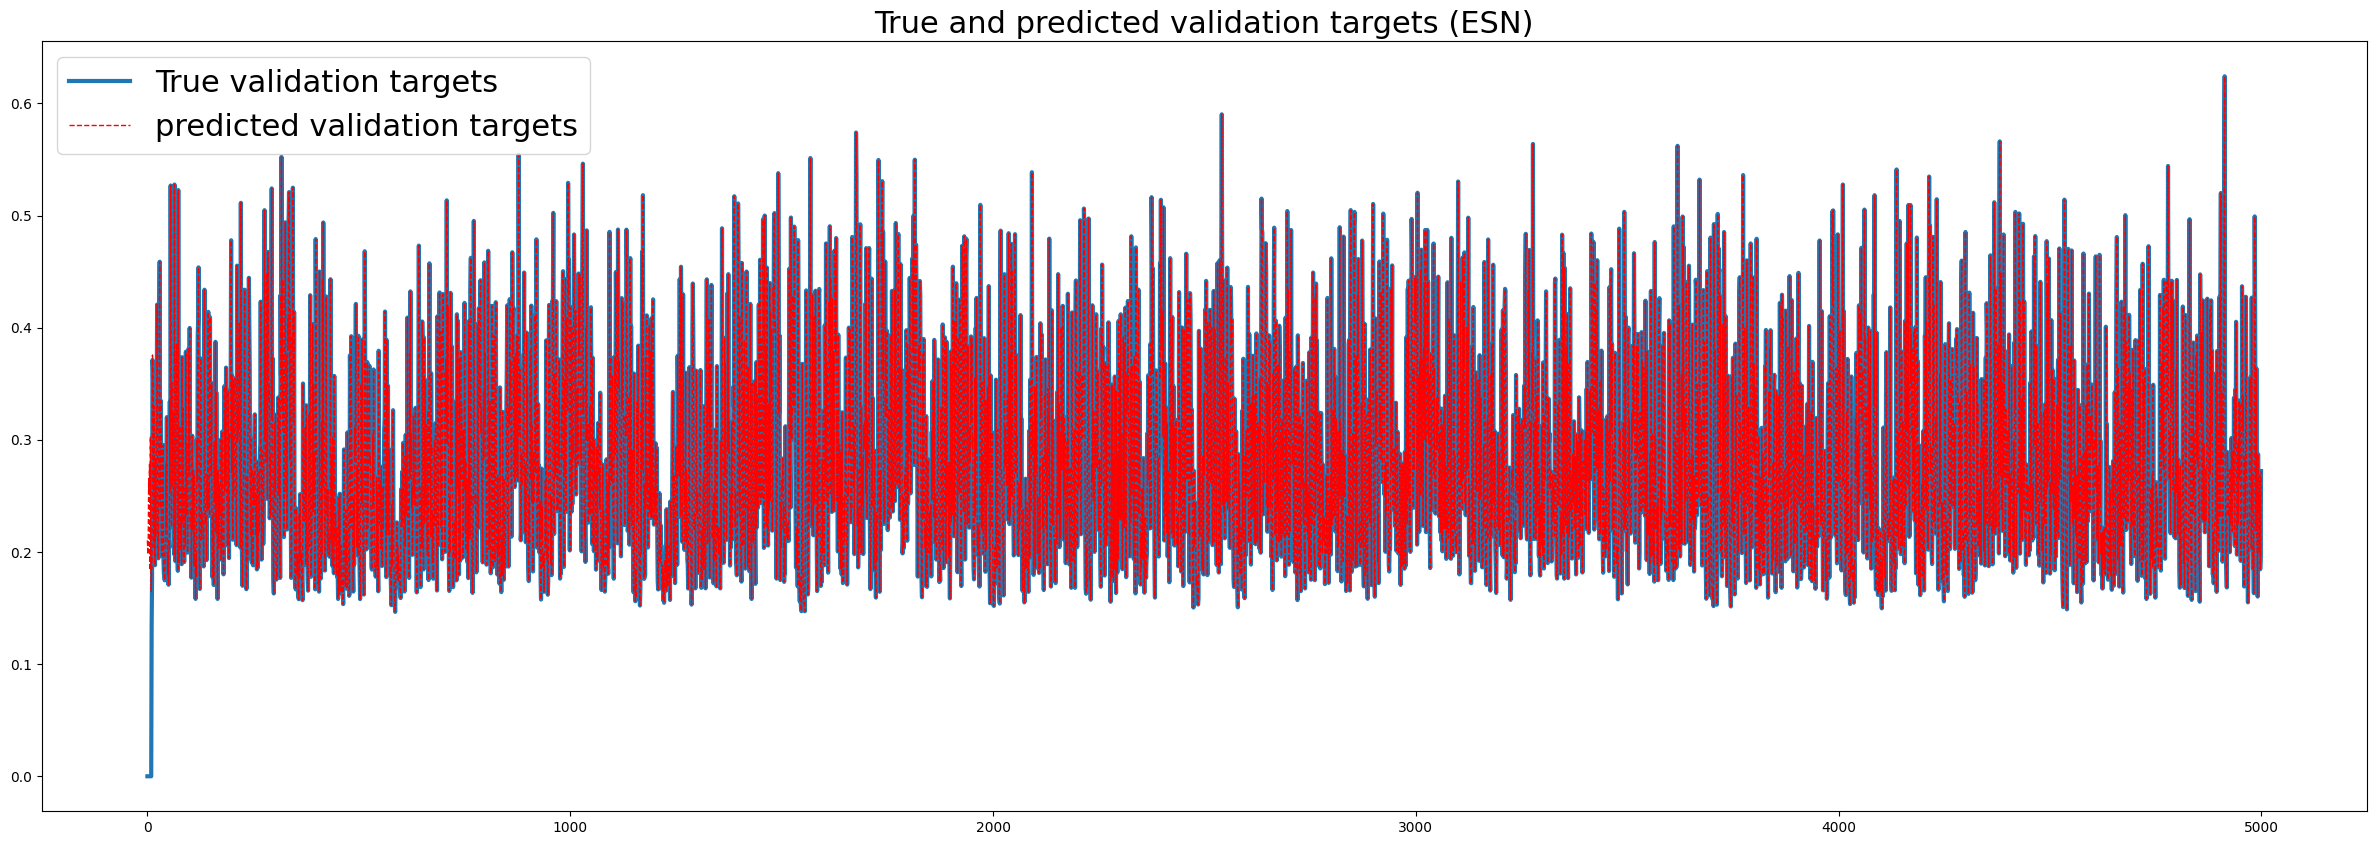

In [41]:
y_pred_dev = esn.predict(x_dev)
plt.figure(figsize=(30,10))
plt.plot(y_dev, label ='True training targets', linewidth=3)
plt.plot(y_pred_dev, label ='predicted training targets', linestyle = '--', color='r', linewidth=1)
plt.title('True and predicted training targets (ESN)', fontsize=22)
plt.legend(fontsize=22)
plt.show()

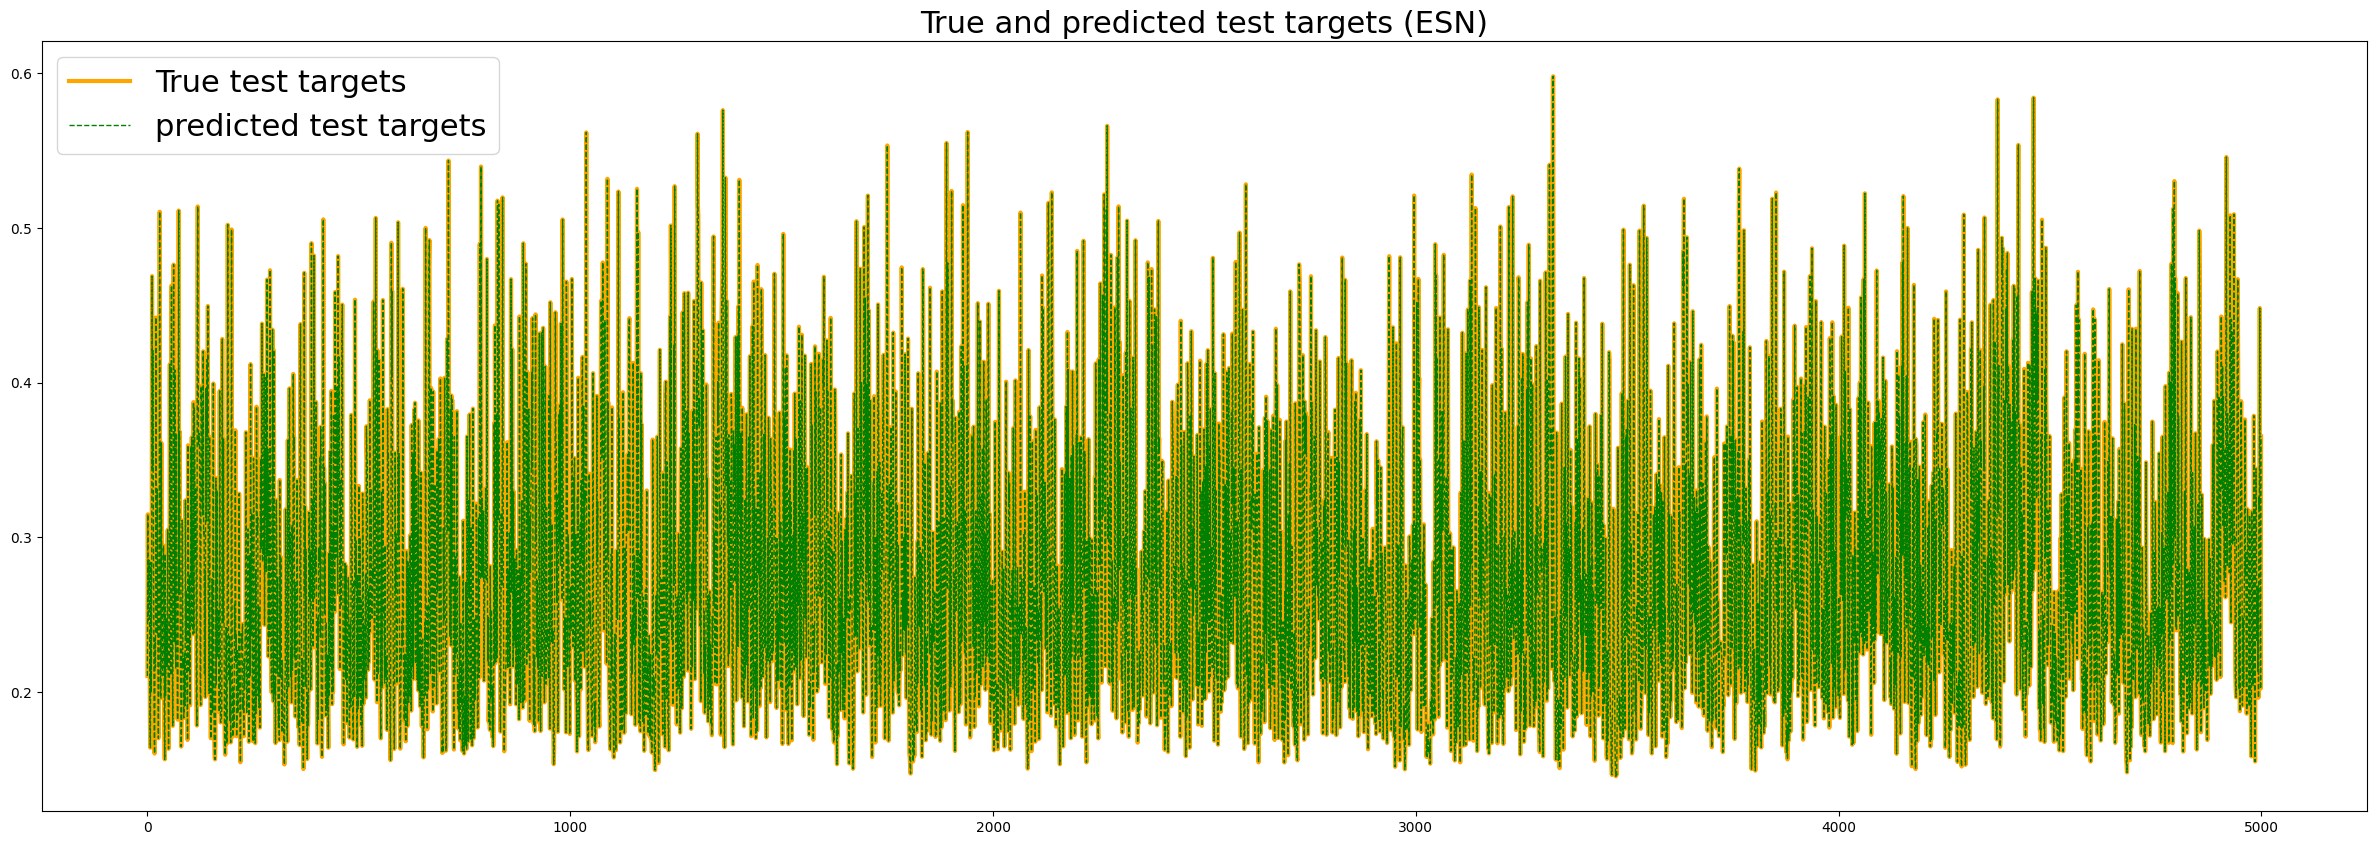

In [43]:
plt.figure(figsize=(30,10))
plt.plot(y_test, label ='True test targets', linewidth=3, color='orange')
plt.plot(y_pred, label ='predicted test targets', linestyle = '--', color='green', linewidth=1)
plt.title('True and predicted test targets (ESN)', fontsize=22)
plt.legend(fontsize=22)
plt.show()

In [48]:
# save weights
np.save('models/esn_h.npy', esn.W_h)
np.save('models/esn_x.npy', esn.W_x)
np.save('models/esn_weights.npy', esn.head.W)
np.save('models/esn_bias.npy', esn.bias)


In [51]:
final_results ={
    'hyperparameters': {
        'hidden_size': hidden_size,
        'rho_h': rho_h,
        'omega_x': omega_x,
        'washout': washout
    },
    'Test mae': mae(y_test, y_pred),
    'Test mse': mse(y_test, y_pred),
    'Train mae': mae(y_dev, y_pred_dev),
    'Train mse': mse(y_dev, y_pred_dev)
    }
import json
with open('models/esn_results.json', 'w') as f:
    json.dump(final_results, f)

# MG17

In [52]:
mg = pd.read_csv('../dataset/MG17.csv', header=None)

In [53]:
mg=np.array(mg)

In [54]:
# 10 delay
mg.shape
mg_input =mg[:, :-10]
mg_target=mg[:, 10:]

In [55]:
mg_input.shape

(1, 9990)

In [56]:
mg_x_train = mg_input[:,:5000].T
mg_x_val = mg_input[:,5000:6000].T
mg_x_test= mg_input[:,6000:].T

mg_y_train = mg_target[:,:5000].T
mg_y_val = mg_target[:,5000:6000].T
mg_y_test= mg_target[:,6000:].T




In [57]:
esn = EchoStateNetwork(1,500, 1.1,1.1,head=LeastMeanSquares(), density=1)

In [58]:
esn.fit(mg_x_train, mg_y_train)

In [59]:
mg_y_val_pred=esn.predict(mg_x_val)

In [61]:
mae(mg_y_val, mg_y_val_pred), mse(mg_y_val, mg_y_val_pred)

(0.00019723725048266576, 7.2399493751395e-08)

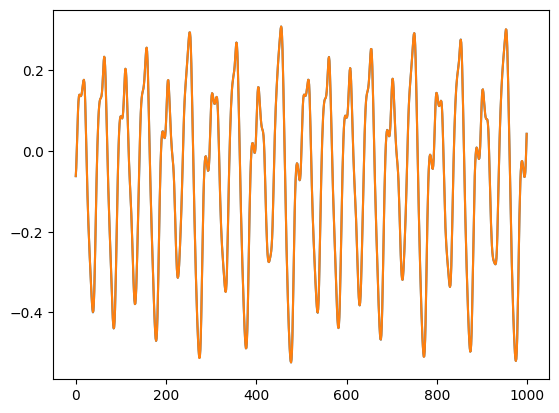

In [62]:
plt.plot(mg_y_val)
plt.plot(mg_y_val_pred)